# Electrostatic Potential Modeling

Use compiled electrostatic energy contributing factors to fit a model to predict PBE calculated electrostatic energy based on embedding scores and distances.

The input is a CSV file with the following columns:
- conf1: Conformer ID for atom 1
- conf2: Conformer ID for atom 2
- distance: Distance between two atoms in Angstroms
- embedding1: Embedding score for atom 1
- embedding2: Embedding score for atom 2
- CoulombPotential: Coulomb potential between two atoms
- PBPotential: Electrostatic energy from Poisson-Boltzmann calculation


In [34]:
# import the modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import joblib
import time

In [2]:
# Constants
D_in = 4.0    # inner dielectric constant (Coulomb potential)
D_out = 80.0  # outter dielectric constant

## Load input data

The input data is a precompiled CSV file in a format like this:
```
Conf1,Conf2,Distance,Embedding1,Embedding2,CoulombPotential,PBPotential
NTR+1A0001_001,LYS01A0001_001,6.632,0.743,0.873,12.518,1.283
NTR+1A0001_001,VAL01A0002_001,5.375,0.743,0.631,15.444,0.401
NTR+1A0001_001,PHE01A0003_001,8.170,0.743,0.828,10.161,0.382
NTR+1A0001_001,ARG03A0005_001,15.648,0.743,0.815,5.305,0.030
NTR+1A0001_001,CYD01A0006_001,18.473,0.743,0.748,4.494,0.044
NTR+1A0001_001,GLU02A0007_001,14.176,0.743,0.413,5.856,0.103
NTR+1A0001_001,LEU01A0008_001,11.396,0.743,0.998,7.285,0.291
NTR+1A0001_001,ALA01A0009_001,17.283,0.743,0.999,4.803,0.082
NTR+1A0001_001,ALA01A0010_001,16.698,0.743,0.776,4.972,0.071
NTR+1A0001_001,ALA01A0011_001,12.609,0.743,0.876,6.584,0.136
NTR+1A0001_001,MET01A0012_001,16.311,0.743,1.000,5.090,0.139
NTR+1A0001_001,LYS+1A0013_001,23.282,0.743,0.541,3.566,0.015
NTR+1A0001_001,ARG03A0014_001,16.374,0.743,0.624,5.070,0.048
NTR+1A0001_001,HIS+1A0015_001,14.668,0.743,0.739,5.660,0.082
NTR+1A0001_001,LEU01A0017_001,19.218,0.743,1.000,4.320,0.086
NTR+1A0001_001,ASP-1A0018_001,24.634,0.743,0.811,3.370,0.006
NTR+1A0001_001,ASN01A0019_001,27.340,0.743,0.633,3.036,0.003
NTR+1A0001_001,TYR01A0020_001,24.587,0.743,0.769,3.376,0.009
NTR+1A0001_001,ARG03A0021_001,30.245,0.743,0.488,2.745,0.005
NTR+1A0001_001,TYR01A0023_001,26.788,0.743,0.878,3.099,0.018
NTR+1A0001_001,SER01A0024_001,25.644,0.743,0.803,3.237,0.008
NTR+1A0001_001,LEU01A0025_001,20.209,0.743,0.975,4.108,0.042
NTR+1A0001_001,ASN01A0027_001,24.718,0.743,0.911,3.359,0.024
```

**Note:** Although the pair in the above file is a conformer pair, it actually points to two atoms.

This CSV file was created by this procedure:


1. Step 1: Microstate pdb files

Before modeling, you need to have microstate pdb files. A microstate file has the same format as MCCE step2_out.pdb, except only one side chain conformer instead of multiple conformers is given to each residue.

You can create such microstate pdb file using
```
step2.py --writepdb
```
The microstate pdb files are in folder "ga_output".


2. Step 2: Embedding score
Use this command to calculate the embedding score on a selected microstate pdb file
```
embedding_score.py microstate_pdb
```

3. Step 3: step2_out.pdb
This step prepares step2_out.pdb by ele_setup.py.
```
ele_setup.py microstate_pdb
```

This script alters the atom radius and charge so 
- the redius matches the values in embedding score calculation
- the charge is +1 for one random atom in one side chain

This way the atom to atom pairwise interaction is the same as conformer to conformer interaction reported by MCCE step3.

4. Step 4: Run delphi using step3.py.

When step2_out.pdb is ready, we will switch to MCCE4 to use step3.py run delphi
```
step3.py -s delphi
```

5. Step 5: Compile ele from delphi and embedding score to a csv file
At this point, you should have an energies directory with opp files. The ele_compile.py will grab information from opp files and embedding score to make a csv file.

```
ele_compile microstate
```
Columns in CSV file:
- Conf1
- Conf2
- Distance
- Embedding1
- Embedding2
- CoulombPotential
- PBPotential

6. Modeling
Use script:
- ele_fitting.py



In [3]:
input_csv = "state_0001_compiled.csv"
data = pd.read_csv(input_csv)

In [4]:
# Check if required columns are present
required_columns = ['Conf1', 'Conf2', 'Distance', 'Embedding1', 'Embedding2', 'CoulombPotential', 'PBPotential']
for col in required_columns:
    if col not in data.columns:
        print(f"Missing required column: {col}")
        exit()

In [5]:
# Prepare features and target variable
X = data[['Distance', 'Embedding1', 'Embedding2', 'CoulombPotential']]
y = data['PBPotential']

## Add a column that is related to delphi ele more than raw inputs
The hypothesis is fully embedded pair of atoms would have the same potential as the Coulomb's potential at inner dielectric constant and fully exposed pair would have potential at outter dielectric constant.

CoulomPotentialAdjusted is taking the above into consideration. Is this quantity linearly related to delphi ele? We don't know, but ML will estabilish a model for us.

In [6]:
# Add columns that are likely to contribute to the model
X = X.copy()
X['EmbeddingAverage'] = (X['Embedding1'] + X['Embedding2']) / 2
# PBPotential = CoulombPotential * EmbeddingAverage + CoulombPotential * (1 - EmbeddingAverage) * D_in/D_out 
X['CoulombPotentialAdjusted'] = X['CoulombPotential'] * (D_in / D_out) * (1 - X['EmbeddingAverage']) + X['CoulombPotential'] * X['EmbeddingAverage']


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Fit a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [9]:
# Predict on the test set
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the linear model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)


In [10]:
# Print MSA and R^2 with reference values (good or bad)
print(f"Linear Regression Model - MSE: {mse_linear:.4f} (Good if < 0.1)")
print(f"Linear Regression Model - R^2: {r2_linear:.4f} (Good if > 0.8)")
print(f"Linear Regression Model - Coefficients: {linear_model.coef_}")
print(f"Linear Regression Model - Intercept: {linear_model.intercept_}")  

Linear Regression Model - MSE: 0.1817 (Good if < 0.1)
Linear Regression Model - R^2: 0.8732 (Good if > 0.8)
Linear Regression Model - Coefficients: [ 0.49647312 -0.24331861 -0.24367897 -3.07001003 -0.3477564   4.90999899]
Linear Regression Model - Intercept: 0.4834430072122933


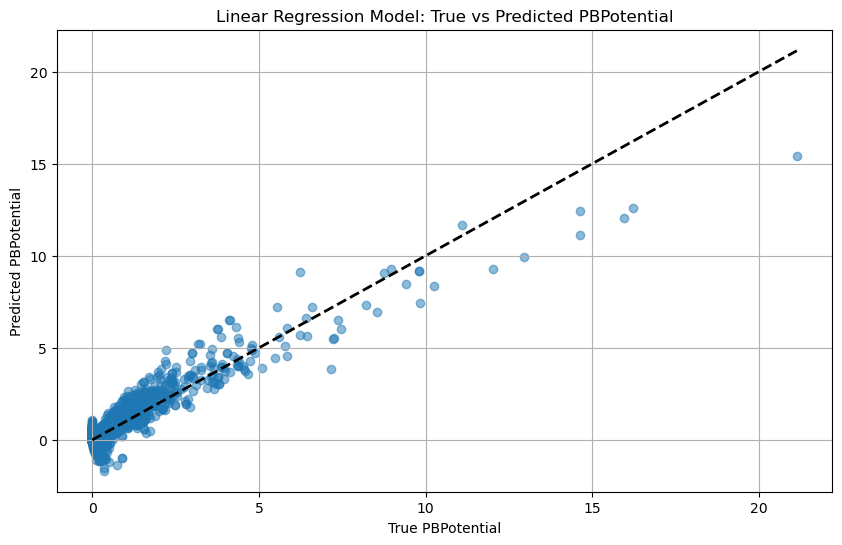

In [11]:
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('Linear Regression Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('linear_regression_results.png')
plt.show()


In [12]:
importances = linear_model.coef_  # the importance is measured by coffeicients
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)


Feature Importances:
                    Feature  Importance
5  CoulombPotentialAdjusted    4.909999
0                  Distance    0.496473
1                Embedding1   -0.243319
2                Embedding2   -0.243679
4          EmbeddingAverage   -0.347756
3          CoulombPotential   -3.070010


Random Forest Model - MSE: 0.0283 (Good if < 0.1)
Random Forest Model - R^2: 0.9802 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.00951922 0.00542274 0.00417979 0.0067018  0.07853632 0.89564012]


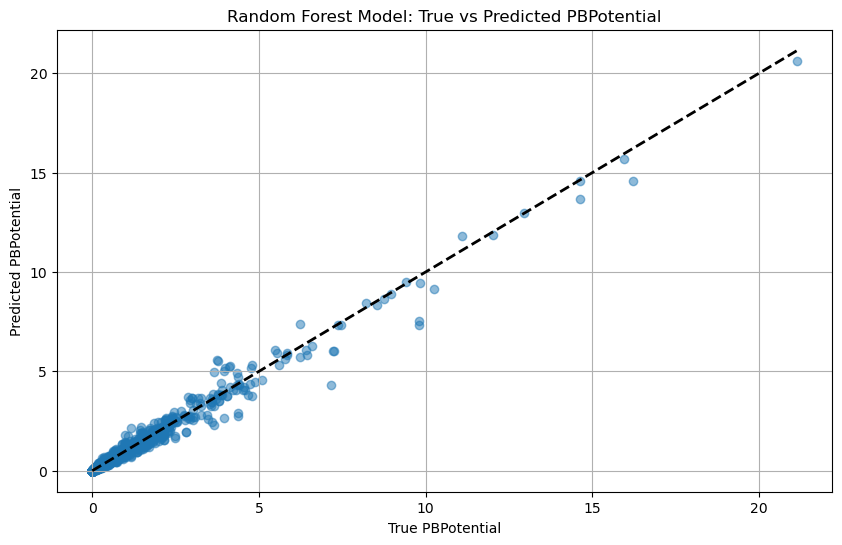

In [13]:
# Fit a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
# Print MSA and R^2 with reference values (good or bad)
print(f"Random Forest Model - MSE: {mse_rf:.4f} (Good if < 0.1)")
print(f"Random Forest Model - R^2: {r2_rf:.4f} (Good if > 0.8)")
print(f"Random Forest Model - Feature Importances: {rf_model.feature_importances_}")
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('Random Forest Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('random_forest_results.png')
plt.show()

In [14]:
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

Feature Importances:
                    Feature  Importance
5  CoulombPotentialAdjusted    0.895640
4          EmbeddingAverage    0.078536
0                  Distance    0.009519
3          CoulombPotential    0.006702
1                Embedding1    0.005423
2                Embedding2    0.004180


XGBoost Model - MSE: 0.0429 (Good if < 0.1)
XGBoost Model - R^2: 0.9700 (Good if > 0.8)
XGBoost Model - Feature Importances: [0.00828462 0.00710008 0.00752731 0.00446877 0.08256298 0.89005625]


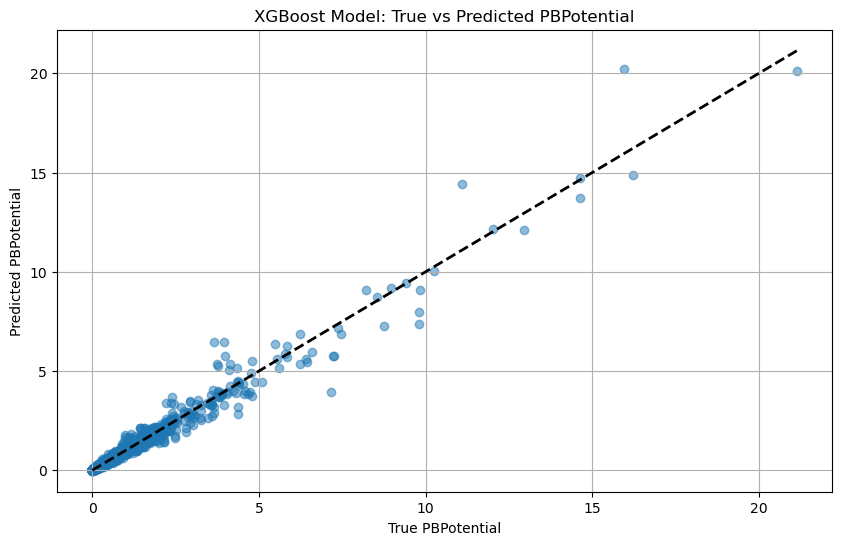

Feature Importances:
                    Feature  Importance
5  CoulombPotentialAdjusted    0.890056
4          EmbeddingAverage    0.082563
0                  Distance    0.008285
2                Embedding2    0.007527
1                Embedding1    0.007100
3          CoulombPotential    0.004469


In [15]:
# Fit an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train_scaled, y_train)
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
# Print MSA and R^2 with reference values (good or bad)
print(f"XGBoost Model - MSE: {mse_xgb:.4f} (Good if < 0.1)")
print(f"XGBoost Model - R^2: {r2_xgb:.4f} (Good if > 0.8)")
print(f"XGBoost Model - Feature Importances: {xgb_model.feature_importances_}")
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('XGBoost Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('xgboost_results.png')
plt.show()
# print the feature importances
importances = xgb_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)


## Only keep the major component

In X, CoulombPotentialAdjusted is computed from 3 variables: CoulombPotential, Embedding1 and Embedding2. We will use CoulombPotentialAdjusted to replace these 3 variables.

In [17]:
X_dropped = X.drop(columns=['Embedding1', 'Embedding2', 'EmbeddingAverage', 'CoulombPotential'])

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
# Linear Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [28]:
# Predict on the test set
y_pred_linear = lr_model.predict(X_test_scaled)

# Evaluate the linear model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

# Print MSA and R^2 with reference values (good or bad)
print(f"Linear Regression Model - MSE: {mse_linear:.4f} (Good if < 0.1)")
print(f"Linear Regression Model - R^2: {r2_linear:.4f} (Good if > 0.8)")

importances = lr_model.coef_  # the importance is measured by coffeicients
feature_names = X_dropped.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

Linear Regression Model - MSE: 0.2579 (Good if < 0.1)
Linear Regression Model - R^2: 0.8200 (Good if > 0.8)
Feature Importances:
                    Feature  Importance
1  CoulombPotentialAdjusted    1.856613
0                  Distance    0.793938


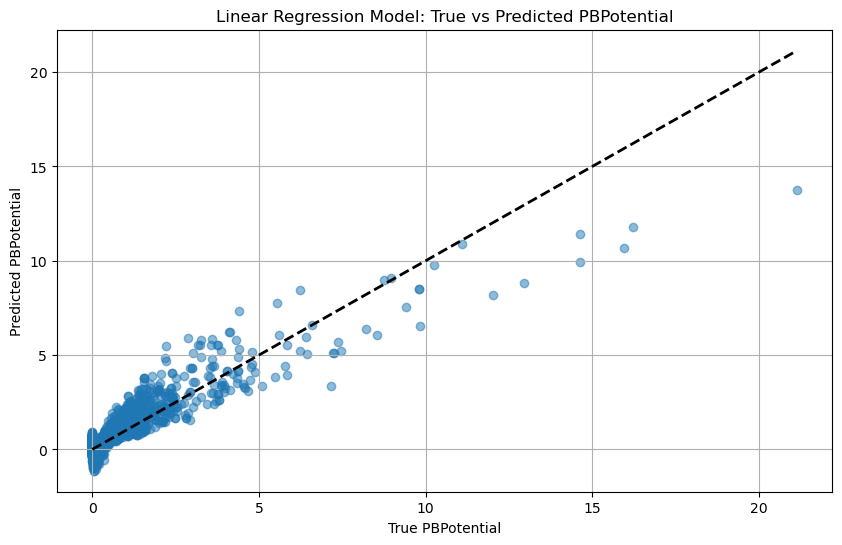

In [29]:
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('Linear Regression Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('linear_regression_results.png')
plt.show()


Random Forest Model - MSE: 0.0210 (Good if < 0.1)
Random Forest Model - R^2: 0.9854 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05931589 0.94068411]


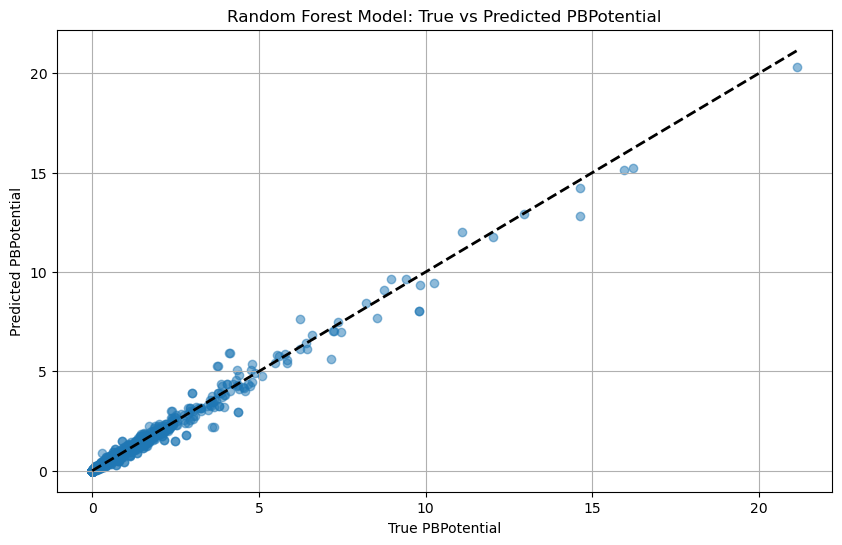

Feature Importances:
                    Feature  Importance
1  CoulombPotentialAdjusted    0.940684
0                  Distance    0.059316


In [31]:
# Fit a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)
# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
# Print MSA and R^2 with reference values (good or bad)
print(f"Random Forest Model - MSE: {mse_rf:.4f} (Good if < 0.1)")
print(f"Random Forest Model - R^2: {r2_rf:.4f} (Good if > 0.8)")
print(f"Random Forest Model - Feature Importances: {rf_model.feature_importances_}")
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('Random Forest Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('random_forest_results.png')
plt.show()

importances = rf_model.feature_importances_
feature_names = X_dropped.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

XGBoost Model - MSE: 0.1052 (Good if < 0.1)
XGBoost Model - R^2: 0.9266 (Good if > 0.8)
XGBoost Model - Feature Importances: [0.03400085 0.9659991 ]


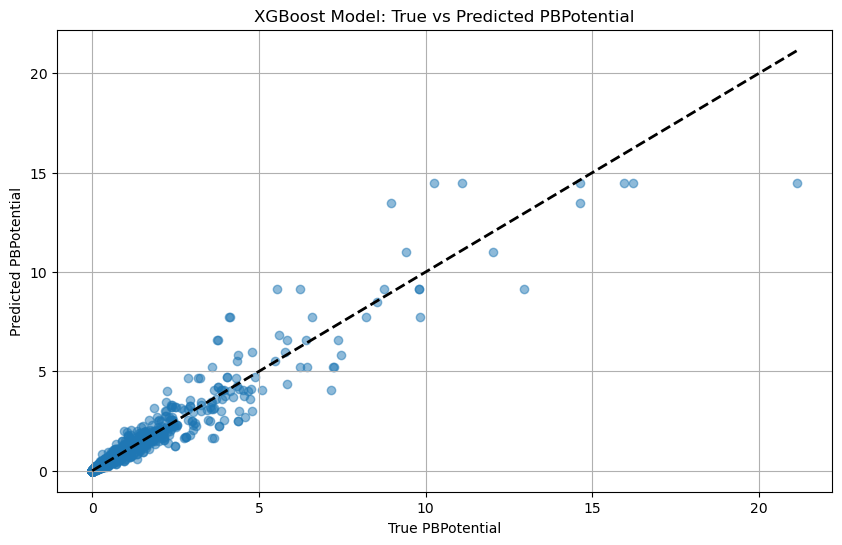

Feature Importances:
                    Feature  Importance
1  CoulombPotentialAdjusted    0.965999
0                  Distance    0.034001


In [32]:
# Fit an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
xgb_model.fit(X_train_scaled, y_train)
# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
# Evaluate the XGBoost model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
# Print MSA and R^2 with reference values (good or bad)
print(f"XGBoost Model - MSE: {mse_xgb:.4f} (Good if < 0.1)")
print(f"XGBoost Model - R^2: {r2_xgb:.4f} (Good if > 0.8)")
print(f"XGBoost Model - Feature Importances: {xgb_model.feature_importances_}")
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True PBPotential')
plt.ylabel('Predicted PBPotential')
plt.title('XGBoost Model: True vs Predicted PBPotential')
plt.grid()
# plt.savefig('xgboost_results.png')
plt.show()
# print the feature importances
importances = xgb_model.feature_importances_
feature_names = X_dropped.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)


## Compare random seeds - using random forest regressor
Does the model depend on the rendom seeds?

Random Forest Model - MSE: 0.0208 (Good if < 0.1)
Random Forest Model - R^2: 0.9829 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05639874 0.94360126]


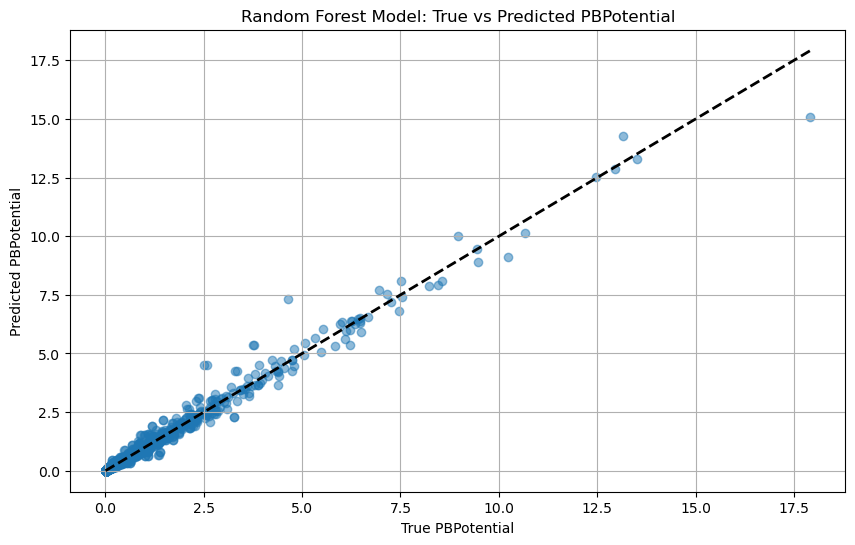

Random Forest Model - MSE: 0.0337 (Good if < 0.1)
Random Forest Model - R^2: 0.9839 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05858604 0.94141396]


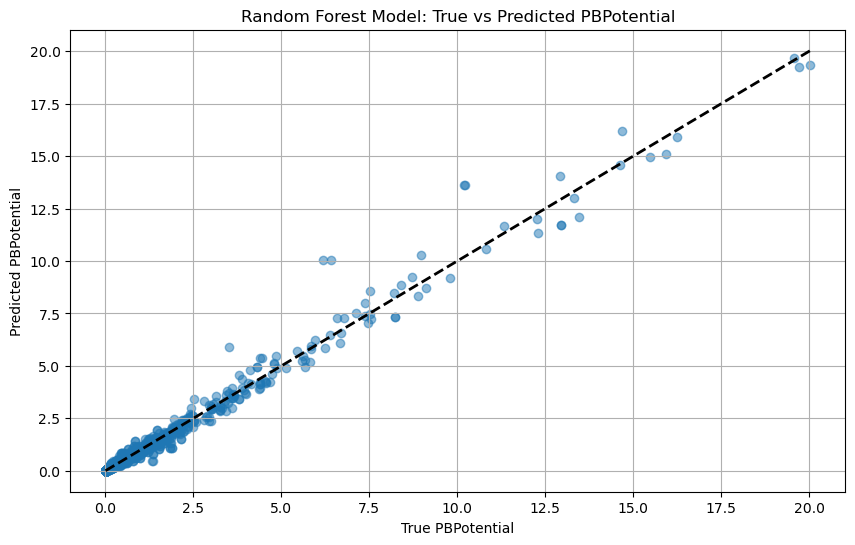

Random Forest Model - MSE: 0.0234 (Good if < 0.1)
Random Forest Model - R^2: 0.9871 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05421383 0.94578617]


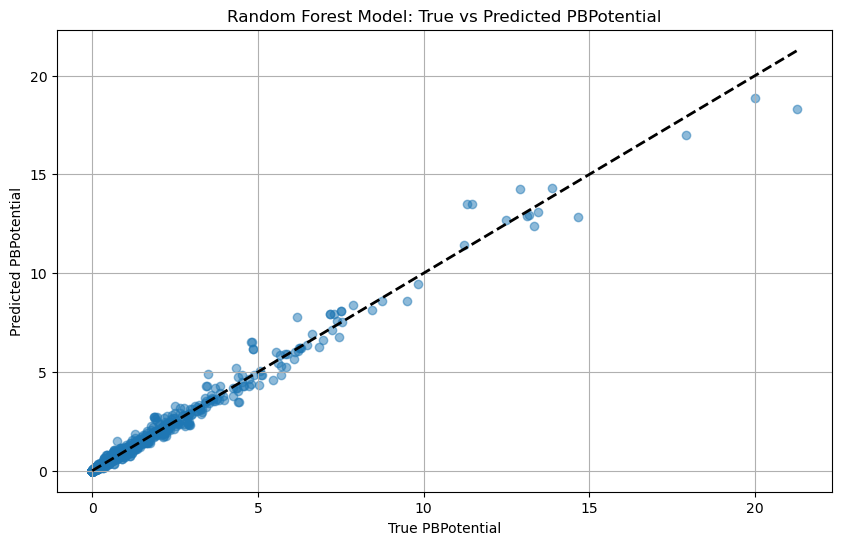

Random Forest Model - MSE: 0.0209 (Good if < 0.1)
Random Forest Model - R^2: 0.9878 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05599028 0.94400972]


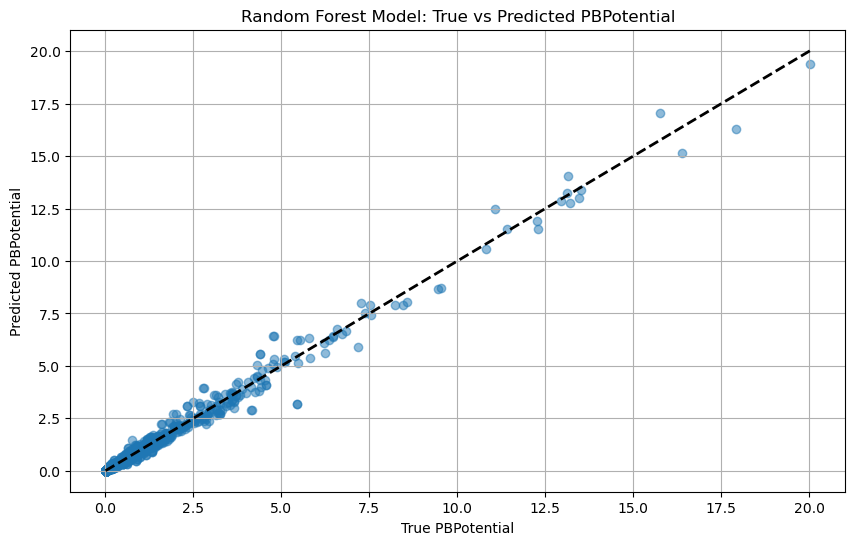

Random Forest Model - MSE: 0.0359 (Good if < 0.1)
Random Forest Model - R^2: 0.9785 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05409646 0.94590354]


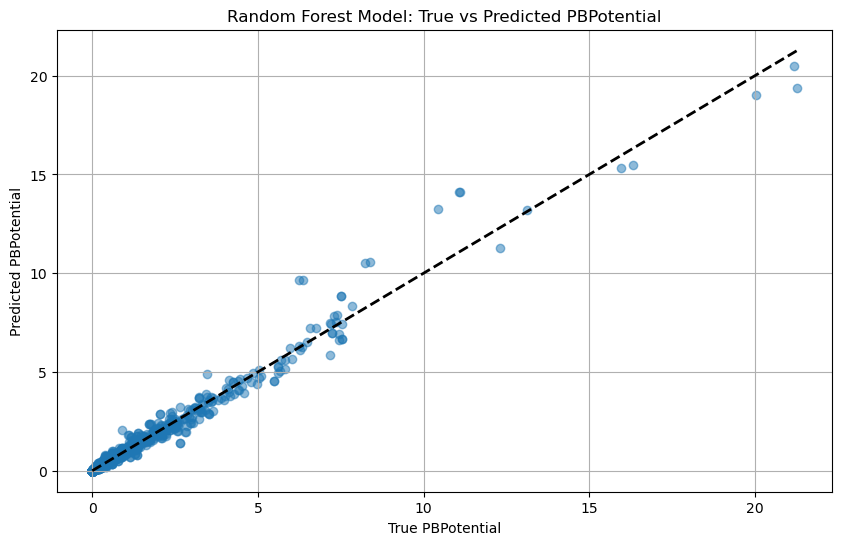

Random Forest Model - MSE: 0.0242 (Good if < 0.1)
Random Forest Model - R^2: 0.9881 (Good if > 0.8)
Random Forest Model - Feature Importances: [0.05992915 0.94007085]


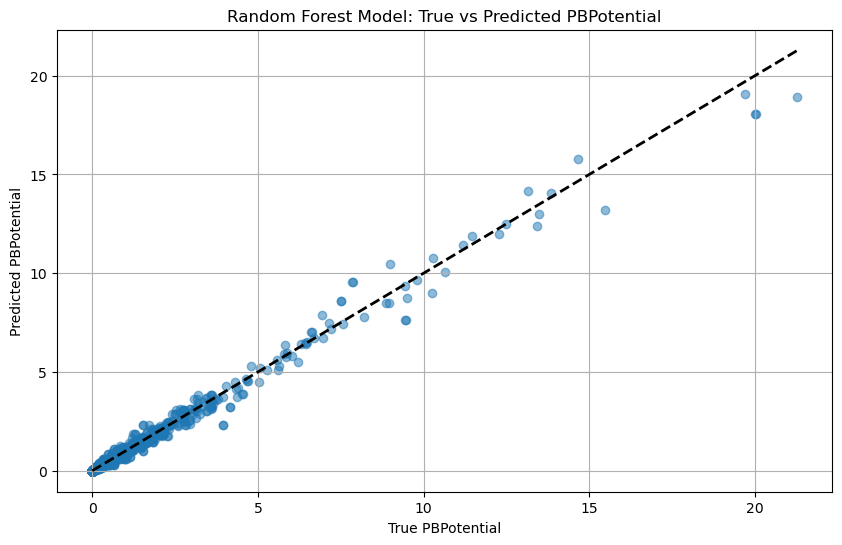

Model MSE variation:  0.026 +- 0.007


In [43]:
# split training and testing sets by random
import statistics

N = 6
MSEs = []
for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.2, random_state=int(time.time()))

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit a Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=int(time.time()))
    rf_model.fit(X_train_scaled, y_train)
    # Predict on the test set
    y_pred_rf = rf_model.predict(X_test_scaled)
    # Evaluate the Random Forest model
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    # Print MSA and R^2 with reference values (good or bad)
    print(f"Random Forest Model - MSE: {mse_rf:.4f} (Good if < 0.1)")
    print(f"Random Forest Model - R^2: {r2_rf:.4f} (Good if > 0.8)")
    print(f"Random Forest Model - Feature Importances: {rf_model.feature_importances_}")
    # plot the results
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('True PBPotential')
    plt.ylabel('Predicted PBPotential')
    plt.title('Random Forest Model: True vs Predicted PBPotential')
    plt.grid()
    # plt.savefig('random_forest_results.png')
    plt.show()

    MSEs.append(mse_rf)

MSE_mean = statistics.mean(MSEs)
MSE_stdev = statistics.stdev(MSEs)

print(f"Model MSE variation: {MSE_mean: .3f} +- {MSE_stdev:.3f}")

In [ ]:
## Can a model fitted from one microstate be used to predict another microstate?
We will fit a model with one microstate and check the performance of predicting other microstates.

This is critically important. If it w